# DATASCI W261: Machine Learning at Scale
## Assignment Week 10
Minhchau Dang (minhchau.dang@berkeley.edu), Miki Seltzer (miki.seltzer@berkeley.edu)<br>
W261-2, Spring 2016<br>
Submission: 3/29/16

# Start PySpark

In [1]:
!export SPARK_HOME=/usr/lib/spark

In [2]:
import os
import sys
spark_home = os.environ.get('SPARK_HOME', None)

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))
 

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.0-cdh5.5.0
      /_/

Using Python version 2.7.11 (default, Dec  6 2015 18:08:32)
SparkContext available as sc, HiveContext available as sqlContext.


# HW 10.0
## What is Apache Spark and how is it different to Apache Hadoop? 

Like Apache Hadoop, Apache Spark is a distributed computing framework for handling big data problems. However, Spark is a much faster processing engine than we have currently been using. It can run on top of Hadoop clusters, or in standalone mode. It is built to use data that is not only stored in HDFS, but also in Hadoop-based systems like HBase, Hive, Cassandra, etc. It can also ingest local text files, CSV files, etc.

Spark's main difference from Hadoop is that processing in Spark is done in memory via RDD (Resilient Distributed Datasets), which allows iterative jobs to be completed much more efficiently. It is strictly focused on the computing aspect of distributed computing, and as a result, Spark does not try to solve the problem of distributed storage and it does not attempt to solve distributed resource management, but rather builds on top of the pre-existing solutions.

## Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, __Python, Scala__ languages (list languages). 

Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or __YARN__ in a distributed manner.

## What is an RDD and show a fun example of creating one and bringing the first element back to the driver program.

An RDD is a resilient distributed dataset with the following properties:
- Distributed storage
- Immutable
- Lazy evaluation
- Can have transformations (similar to mappers) and actions (similar to reducers)
- RDD is not materialized until an action is called (lazy evaluation), when the results are evaluated using a lineage graph
- Results of an action can be cached/persisted so that they are not repetitively processed
- Can be a base RDD (only values) or a pair RDD (key-value pairs)

#### Example:


In [3]:
# Let's pretend we have an array of elements

story = ['once', 'upon', 'a', 'time']

# We convert it into an RDD simply by using "parallelize"

story_rdd = sc.parallelize(story)

# We can retrieve the first element by asking for it with "first"

story_rdd.first()

'once'

## What is lazy evaluation and give an intuitive example of lazy evaluation and comment on the massive computational savings to be had from lazy evaluation.

Lazy evaluation means that an RDD is not materialized until an action is called. Thus, when the RDD is loaded and transformed, the only thing that is really being done is to store the instructions on how the data should be constructed when an action is called. There are computational savings to be had by doing lazy evaluations because the data is not actually materialized until a result needs to be sent back to the driver.

#### Example:
>When working with the 2GB Wikipedia data, if we load the data into an RDD, this should be instantaneous, because we haven't actually performed any actions on it. We can write many transformations and this will all be nearly instantaneous as well, because nothing has been materialized. However, when we want to see the results of our transformation, we can call an action like take(10), and instead of running the transformations on the entire data set, it will only process enough data to return those 10 results that we requested in the action.

>For comparison, if we wanted to do this in Hadoop, we would have had to process the entire 2GB file, which is computationally expensive if we only needed to see 10 resulting records from the data set.

# HW10.1
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document as a the example document to run an experiment.  Report the following: provide a sorted list of tokens in decreasing order of frequency of occurence.


In [12]:
!hdfs dfs -copyFromLocal MIDS-MLS-HW-10.txt /user/miki/week10/hw10_1/

In [4]:
import regex as re

# Function to remove punctuation and split a line
def splitString(line):
    noPunc = re.sub(u'[^A-Za-z0-9 ]+', '', line)
    return noPunc.strip().split()

# Parallelize text file, count words, sort
hwText = sc.textFile('/user/miki/week10/hw10_1/MIDS-MLS-HW-10.txt')
wordCounts = hwText.flatMap(splitString).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)
sortedCounts = wordCounts.map(lambda x: (x[1], x[0])).sortByKey(ascending=False).collect()

# Print result
print '{:5s}  {:10s}'.format('count', 'word')
print '--------------------'
for count, word in sortedCounts:
    print '{:5d}  {:10s}'.format(count, word)

count  word      
--------------------
   46  the       
   24  and       
   18  in        
   17  of        
   13  HW        
   12  a         
   11  for       
   10  data      
   10  code      
    9  to        
    8  is        
    7  with      
    7  this      
    7  Using     
    7  on        
    7  your      
    7  KMeans    
    6  clusters  
    5  iterations
    5  from      
    5  as        
    5  regression
    4  What      
    4  words     
    4  HW103     
    4  Sum       
    4  100       
    4  Comment   
    4  following 
    4  Squared   
    4  Spark     
    4  model     
    4  using     
    4  each      
    4  set       
    4  linear    
    4  example   
    4  one       
    4  x         
    4  Set       
    4  provided  
    3  list      
    3  findings  
    3  evaluation
    3  available 
    3  lazy      
    3  training  
    3  count     
    3  Please    
    3  report    
    3  NOTE      
    3  Errors    
    3  plot      
    3  

# HW 10.1.1

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.

In [5]:
# Parallelize text file, count words and filter, sort
hwText = sc.textFile('/user/miki/week10/hw10_1/MIDS-MLS-HW-10.txt')
wordCounts = hwText.flatMap(splitString).filter(lambda x: x[0].islower()).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)
sortedCounts = wordCounts.map(lambda x: (x[1], x[0])).sortByKey(ascending=False).collect()

# Print results
print '{:5s}  {:10s}'.format('count', 'word')
print '--------------------'
for count, word in sortedCounts:
    print '{:5d}  {:10s}'.format(count, word)

count  word      
--------------------
   46  the       
   24  and       
   18  in        
   17  of        
   12  a         
   11  for       
   10  data      
   10  code      
    9  to        
    8  is        
    7  with      
    7  this      
    7  on        
    7  your      
    6  clusters  
    5  iterations
    5  from      
    5  as        
    5  regression
    4  words     
    4  following 
    4  model     
    4  using     
    4  each      
    4  x         
    4  set       
    4  linear    
    4  one       
    4  example   
    4  provided  
    3  report    
    3  list      
    3  findings  
    3  evaluation
    3  available 
    3  lazy      
    3  training  
    3  count     
    3  results   
    3  import    
    3  plots     
    3  or        
    3  plot      
    3  it        
    3  an        
    3  document  
    3  after     
    3  notebook  
    2  httpswwwdropboxcomsq85t0ytb9apggnhkmeansdatatxtdl0
    2  languages 
    2  homework  
   

# HW 10.2: KMeans a la MLLib

### Use the following  MLlib-centric KMeans code snippet to run k-means

In [11]:
!hdfs dfs -copyFromLocal kmeans_data.txt /user/miki/week10/hw10_2/

copyFromLocal: `/user/miki/week10/hw10_2/kmeans_data.txt': File exists


In [19]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

def runMLLibKMeans(inputFile, k, iterations):
    global clusters
    
    # Load and parse the data
    # NOTE  kmeans_data.txt is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
    data = sc.textFile(inputFile)
    parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

    # Build the model (cluster the data)
    clusters = KMeans.train(parsedData, k, maxIterations=iterations,
                            runs=10, initializationMode="random")

    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("Within Set Sum of Squared Error = " + str(WSSSE))

    # Save and load model
    modelPath = inputFile.replace(inputFile.split('/')[-1], 'myModelPath')
    clusters.save(sc, modelPath)
    sameModel = KMeansModel.load(sc, modelPath)

    return [sameModel, WSSSE]

### List the clusters that you find and compute the Within Set Sum of Squared Errors for the found clusters. 

In [21]:
centroids = runMLLibKMeans('/user/miki/week10/hw10_2/kmeans_data.txt', 2, 10)
sameModel = centroids[0]
print sameModel.clusterCenters

(DenseVector([9.1, 9.1, 9.1]), DenseVector([0.1, 0.1, 0.1]))


### Comment on your findings.

The resulting clusters are centered at (9.1, 9.1, 9.1) and (0.1, 0.1, 0.1), with a within set sum of squared error 0.693. The 3D plot below shows that the centroids look reasonable, and are centered within a set of three points each.

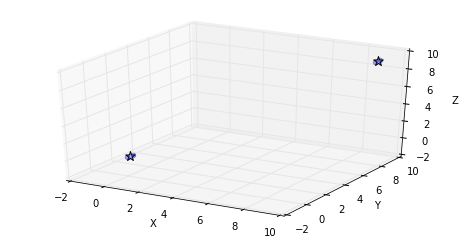

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

X = []
Y = []
Z = []

with open('kmeans_data.txt', 'r') as myfile:
    for line in myfile:
        fields = line.strip().split()
        X.append(float(fields[0]))
        Y.append(float(fields[1]))
        Z.append(float(fields[2]))

# 3D plot the data and centroids
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for i in range(2):
    centroid = list(sameModel.clusterCenters)[i]
    ax.scatter(centroid[0], centroid[1], centroid[2], c='w', depthshade=False, s=100, marker='*')
    
ax.scatter(X, Y, Z, c='b', depthshade=False, alpha=0.3)
plt.show()

# HW 10.3

Download the following KMeans notebook:

https://www.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb?dl=0

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

- Plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
- In each plot please report the Within Set Sum of Squared Errors for the found clusters.

## Data generation

In [24]:
import numpy as np
import pylab 
import json

size1 = size2 = size3 = 100

samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1

samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)

samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)

# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv', data, delimiter = ' ', fmt='%.10f')

In [116]:
!hdfs dfs -rm /user/miki/week10/hw10_3/data.csv
!hdfs dfs -copyFromLocal data.csv /user/miki/week10/hw10_3/

Deleted /user/miki/week10/hw10_3/data.csv


## Data visualization

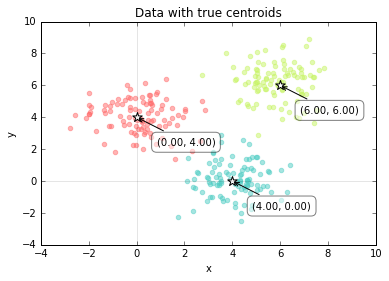

In [25]:
def plot_samples(title, means):
    # Plot axis
    plt.axhline(0, color='black', alpha=0.1)
    plt.axvline(0, color='black', alpha=0.1)
    
    # Plot data points
    plt.scatter(samples1[:, 0], samples1[:, 1], color='#4ECDC4', alpha=0.5)
    plt.scatter(samples2[:, 0], samples2[:, 1], color='#C7F464', alpha=0.5)
    plt.scatter(samples3[:, 0], samples3[:, 1], color='#FF6B6B', alpha=0.5)
    
    # Plot centroids
    plt.scatter(means[0][0], means[0][1], marker='*', s=100, color='white', edgecolor='black')
    plt.scatter(means[1][0], means[1][1], marker='*', s=100, color='white', edgecolor='black')
    plt.scatter(means[2][0], means[2][1], marker='*', s=100, color='white', edgecolor='black')
    
    # Annotate centroids
    for i in means:
        text = '({:.2f}'.format(i[0]) + ', ' + '{:.2f})'.format(i[1])
        plt.annotate(text, 
            xy = i, xytext = (20, -20),
            textcoords = 'offset points', ha = 'left', va = 'top',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
    # Label graph
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')

plot_samples('Data with true centroids', [[0,4],[6,6],[4,0]])

## Run MLLib K-means

In [27]:
allCentroids = []
ks = [1, 10, 20, 100]

for k in ks:
    inputFile = '/user/miki/week10/hw10_3/data.csv'
    !hdfs dfs -rm -r {inputFile.replace('data.csv', 'myModelPath')}
    print '\nNumber of iterations =', k
    centroids = runMLLibKMeans(inputFile, 3, k)
    allCentroids.append(centroids)
    print centroids[0].clusterCenters, '\n'

Deleted /user/miki/week10/hw10_3/myModelPath

Number of iterations = 1
Within Set Sum of Squared Error = 377.732587506
(DenseVector([0.0596, 3.8901]), DenseVector([4.0867, 0.1017]), DenseVector([5.9702, 6.1846])) 

Deleted /user/miki/week10/hw10_3/myModelPath

Number of iterations = 10
Within Set Sum of Squared Error = 377.732587506
(DenseVector([0.0596, 3.8901]), DenseVector([5.9702, 6.1846]), DenseVector([4.0867, 0.1017])) 

Deleted /user/miki/week10/hw10_3/myModelPath

Number of iterations = 20
Within Set Sum of Squared Error = 377.732587506
(DenseVector([0.0596, 3.8901]), DenseVector([4.0867, 0.1017]), DenseVector([5.9702, 6.1846])) 

Deleted /user/miki/week10/hw10_3/myModelPath

Number of iterations = 100
Within Set Sum of Squared Error = 377.732587506
(DenseVector([5.9702, 6.1846]), DenseVector([4.0867, 0.1017]), DenseVector([0.0596, 3.8901])) 



## Plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.

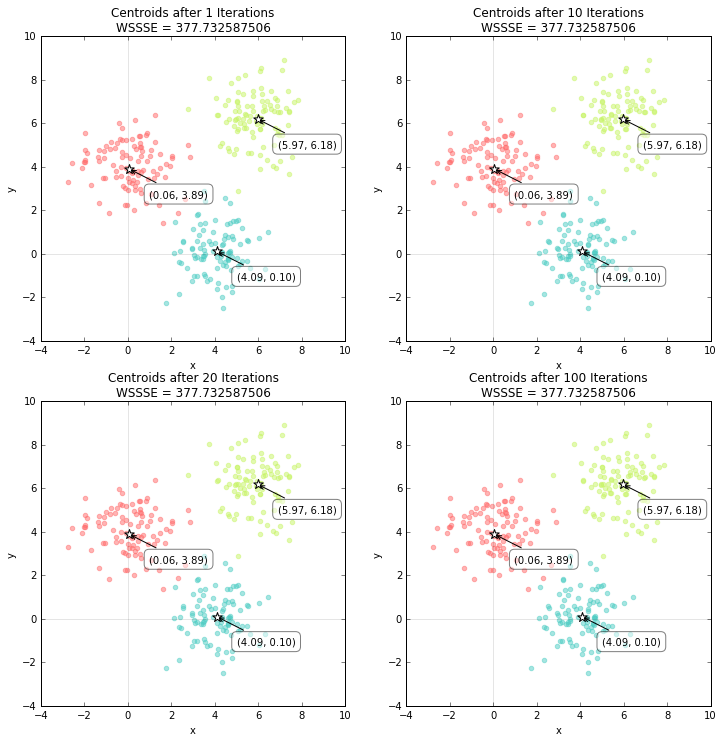

In [29]:
plt.figure(figsize=(12,12))
for i in range(len(ks)):
    plt.subplot(2, 2, i + 1)
    plot_samples('Centroids after '+str(ks[i])+' Iterations\nWSSSE = '+str(allCentroids[i][1]), 
                 allCentroids[i][0].clusterCenters)

### Comment on the progress of WSSSE as the KMeans algorithms runs for more iterations

In the MLLib implementation, the algorithm converges in fewer than 10 iterations. Thus, the resulting centroids for 10, 20 and 100 iterations are the same, and have the same WSSSE.

# HW 10.4

Using the KMeans code (homegrown code) provided repeat the experiments in HW10.3.

In [30]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(' ')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

def plot_iterations(allIterations):
    centroidPaths = np.array(allIterations)
    
    allSamples = np.array(samples1)
    allSamples = np.append(allSamples, samples2, axis=0)
    allSamples = np.append(allSamples, samples3, axis=0)
    
    colors = ['#4ECDC4', '#C7F464', '#FF6B6B']
    
    # Plot axis
    plt.axhline(0, color='black', alpha=0.1)
    plt.axvline(0, color='black', alpha=0.1)
    
    # Plot each cluster
    for i in range(3):
        plt.scatter(allSamples[(i * 100):((i+1) * 100), 0], allSamples[(i * 100):((i+1) * 100), 1], 
                    color=colors[i], alpha=0.5, zorder=1)
        plt.plot(centroidPaths[:,i,0], centroidPaths[:,i,1], color='grey', alpha=0.9,
                 marker='o', markersize=5, markerfacecolor='white', markeredgecolor='black', zorder=2)
        plt.scatter(centroidPaths[-1,i,0], centroidPaths[-1,i,1], marker='*', s=150, 
                    color='white', edgecolor='black', zorder=3)
        
        finalCentroid = centroidPaths[-1, i]
        text = '({:.2f}'.format(finalCentroid[0]) + ', ' + '{:.2f})'.format(finalCentroid[1])
        plt.annotate(text, 
            xy = finalCentroid, xytext = (20, -20),
            textcoords = 'offset points', ha = 'left', va = 'top',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    # Label graph
    plt.title('Samples 1, 2, and 3 with iterated centroid estimates')
    plt.xlabel('x')
    plt.ylabel('y')

In [31]:
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])    

def calcError(line):
    center = centroids[nearest_centroid(line)[0]]
    point = np.array([float(f) for f in line.split(' ')])
    return sqrt(sum([x**2 for x in (point - center)]))

def runKMeans(K, inputFile, iterations):
    global centroids
    
    # Initialization: initialization of parameter is fixed to show an example
    centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])
    
    D = sc.textFile(inputFile).cache()
    
    iter_centroids = []
    iter_centroids.append(centroids)
    iteration = 0
    
    print '{:12s}{:<20s}{:<20s}{:<20s}'.format('Iteration', 'Centroid 1', 'Centroid 2', 'Centroid 3')
    print '----------------------------------------------------------------------'
    rowPrint = '{:<12d}({: 6.4f}, {: 6.4f})  ({: 6.4f}, {: 6.4f})  ({: 6.4f}, {: 6.4f})  '.format
    print rowPrint(iteration,
                   centroids[0][0], centroids[0][1],
                   centroids[1][0], centroids[1][1],
                   centroids[2][0], centroids[2][1])
    
    for i in range(iterations):  
        res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0] + y[0], x[1] + y[1])).collect()
        #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
        #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
        #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
        # res[1][1][1] returns 1000 here
        res = sorted(res, key = lambda x : x[0])  #sort based on clusted ID
        centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
        iter_centroids.append(centroids_new)
        
        if np.sum(np.absolute(centroids_new - centroids))<0.01:
            break
        
        centroids = centroids_new
        iteration += 1
        
        print rowPrint(iteration,
               centroids[0][0], centroids[0][1],
               centroids[1][0], centroids[1][1],
               centroids[2][0], centroids[2][1])
        
    WSSSE = D.map(calcError).reduce(lambda x, y: x + y)
    print '\nWSSSE =', WSSSE
    
    plot_iterations(iter_centroids)

Iteration   Centroid 1          Centroid 2          Centroid 3          
----------------------------------------------------------------------
0           ( 0.0000,  0.0000)  ( 2.0000,  2.0000)  ( 0.0000,  7.0000)  
1           ( 0.2905,  1.1595)  ( 3.9531,  2.4389)  ( 2.4476,  5.8102)  

WSSSE = 845.791382421


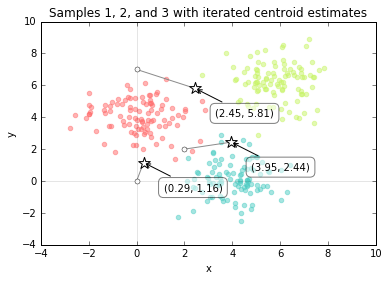

In [32]:
runKMeans(3, "/user/miki/week10/hw10_3/data.csv", 1)

Iteration   Centroid 1          Centroid 2          Centroid 3          
----------------------------------------------------------------------
0           ( 0.0000,  0.0000)  ( 2.0000,  2.0000)  ( 0.0000,  7.0000)  
1           ( 0.2905,  1.1595)  ( 3.9531,  2.4389)  ( 2.4476,  5.8102)  
2           ( 0.0966,  2.7890)  ( 4.7232,  1.2479)  ( 3.8541,  5.9571)  
3           (-0.0112,  3.8292)  ( 4.1171,  0.1361)  ( 5.7952,  6.1775)  
4           ( 0.0596,  3.8901)  ( 4.0867,  0.1017)  ( 5.9702,  6.1846)  

WSSSE = 377.732587506


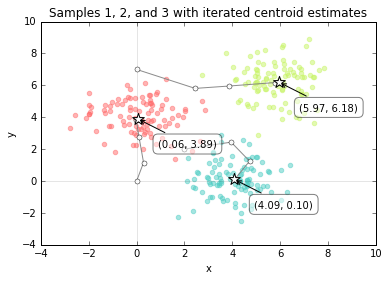

In [33]:
runKMeans(3, "/user/miki/week10/hw10_3/data.csv", 10)

Iteration   Centroid 1          Centroid 2          Centroid 3          
----------------------------------------------------------------------
0           ( 0.0000,  0.0000)  ( 2.0000,  2.0000)  ( 0.0000,  7.0000)  
1           ( 0.2905,  1.1595)  ( 3.9531,  2.4389)  ( 2.4476,  5.8102)  
2           ( 0.0966,  2.7890)  ( 4.7232,  1.2479)  ( 3.8541,  5.9571)  
3           (-0.0112,  3.8292)  ( 4.1171,  0.1361)  ( 5.7952,  6.1775)  
4           ( 0.0596,  3.8901)  ( 4.0867,  0.1017)  ( 5.9702,  6.1846)  

WSSSE = 377.732587506


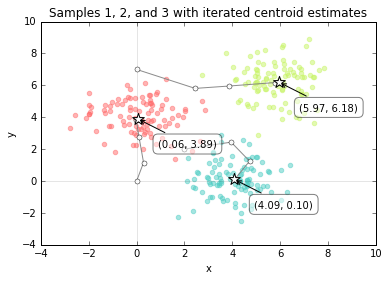

In [34]:
runKMeans(3, "/user/miki/week10/hw10_3/data.csv", 20)

Iteration   Centroid 1          Centroid 2          Centroid 3          
----------------------------------------------------------------------
0           ( 0.0000,  0.0000)  ( 2.0000,  2.0000)  ( 0.0000,  7.0000)  
1           ( 0.2905,  1.1595)  ( 3.9531,  2.4389)  ( 2.4476,  5.8102)  
2           ( 0.0966,  2.7890)  ( 4.7232,  1.2479)  ( 3.8541,  5.9571)  
3           (-0.0112,  3.8292)  ( 4.1171,  0.1361)  ( 5.7952,  6.1775)  
4           ( 0.0596,  3.8901)  ( 4.0867,  0.1017)  ( 5.9702,  6.1846)  

WSSSE = 377.732587506


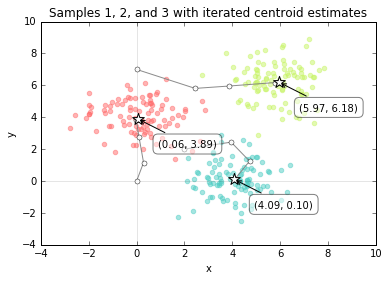

In [35]:
runKMeans(3, "/user/miki/week10/hw10_3/data.csv", 100)

## Comment on any differences between the results in HW10.3 and HW10.4. Explain.

The homegrown algorithm explicitly sets the starting centroids to (0,0), (2,2), and (0,7). The algorithm converges in 4 iterations, so there is no difference between the runs with 10, 20 and 100 iterations. The WSSSE also converges to nearly the same value as with the MLLib implementation

# HW 10.5 (OPTIONAL)

## Run weighted k-means on random data

Using the KMeans code provided modify it to do a weighted KMeans and repeat the experiements in HW10.3.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm):

> $weight(x) = \Large{\frac{1}{\lVert x \rVert}}$

> where $\lVert x \rVert = \sqrt{x \cdot x} = \sqrt{x_1^2 + x_2^2}$

> Here $x$ is vector made up of $x_1$ and $x_2$.

This is essentially identical to the original, but we add an additional `map` step that converts the unweighted point into a weighted point.

In [36]:
from numpy.linalg import norm

def weighted_point(value):
    cluster_id = value[0]

    point = value[1][0]
    new_weight = 1.0 / norm(point)

    return cluster_id, (point * new_weight, new_weight)

def runWeightedKMeans(K, inputFile, iterations):
    global centroids
    
    # Initialization: initialization of parameter is fixed to show an example
    centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])
    
    D = sc.textFile(inputFile).cache()
    
    iter_centroids = []
    iter_centroids.append(centroids)
    iteration = 0
    
    print '{:12s}{:<20s}{:<20s}{:<20s}'.format('Iteration', 'Centroid 1', 'Centroid 2', 'Centroid 3')
    print '----------------------------------------------------------------------'
    rowPrint = '{:<12d}({: 6.4f}, {: 6.4f})  ({: 6.4f}, {: 6.4f})  ({: 6.4f}, {: 6.4f})  '.format
    print rowPrint(iteration,
                   centroids[0][0], centroids[0][1],
                   centroids[1][0], centroids[1][1],
                   centroids[2][0], centroids[2][1])
    
    for i in range(iterations):  
        res = D.map(nearest_centroid).map(weighted_point).reduceByKey(lambda x,y : (x[0] + y[0], x[1] + y[1])).collect()
        res = sorted(res, key = lambda x : x[0])  #sort based on clusted ID
        centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
        iter_centroids.append(centroids_new)
        
        if np.sum(np.absolute(centroids_new - centroids))<0.01:
            break
        
        centroids = centroids_new
        iteration += 1
        
        print rowPrint(iteration,
               centroids[0][0], centroids[0][1],
               centroids[1][0], centroids[1][1],
               centroids[2][0], centroids[2][1])
        
    WSSSE = D.map(calcError).reduce(lambda x, y: x + y)
    print '\nWSSSE =', WSSSE
    
    plot_iterations(iter_centroids)

Iteration   Centroid 1          Centroid 2          Centroid 3          
----------------------------------------------------------------------
0           ( 0.0000,  0.0000)  ( 2.0000,  2.0000)  ( 0.0000,  7.0000)  
1           ( 0.2148,  1.2093)  ( 3.2545,  1.9236)  ( 1.4917,  5.3409)  

WSSSE = 863.629975914


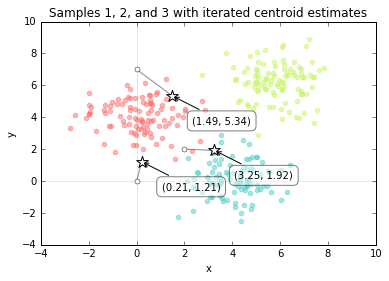

In [37]:
runWeightedKMeans(3, "/user/miki/week10/hw10_3/data.csv", 1)

Iteration   Centroid 1          Centroid 2          Centroid 3          
----------------------------------------------------------------------
0           ( 0.0000,  0.0000)  ( 2.0000,  2.0000)  ( 0.0000,  7.0000)  
1           ( 0.2148,  1.2093)  ( 3.2545,  1.9236)  ( 1.4917,  5.3409)  
2           (-0.3447,  2.7134)  ( 4.1510,  0.8470)  ( 2.1913,  5.1675)  
3           (-0.2584,  3.3841)  ( 3.8781,  0.1284)  ( 4.1677,  5.5618)  
4           (-0.0084,  3.6244)  ( 3.8462,  0.0908)  ( 5.7264,  6.0241)  
5           ( 0.0379,  3.6506)  ( 3.8462,  0.0908)  ( 5.8967,  6.0799)  

WSSSE = 381.417236


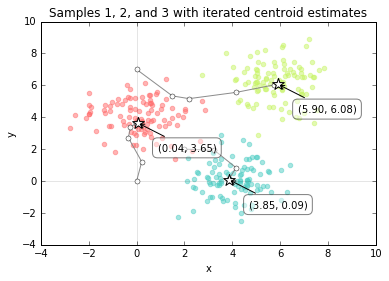

In [38]:
runWeightedKMeans(3, "/user/miki/week10/hw10_3/data.csv", 10)

Iteration   Centroid 1          Centroid 2          Centroid 3          
----------------------------------------------------------------------
0           ( 0.0000,  0.0000)  ( 2.0000,  2.0000)  ( 0.0000,  7.0000)  
1           ( 0.2148,  1.2093)  ( 3.2545,  1.9236)  ( 1.4917,  5.3409)  
2           (-0.3447,  2.7134)  ( 4.1510,  0.8470)  ( 2.1913,  5.1675)  
3           (-0.2584,  3.3841)  ( 3.8781,  0.1284)  ( 4.1677,  5.5618)  
4           (-0.0084,  3.6244)  ( 3.8462,  0.0908)  ( 5.7264,  6.0241)  
5           ( 0.0379,  3.6506)  ( 3.8462,  0.0908)  ( 5.8967,  6.0799)  

WSSSE = 381.417236


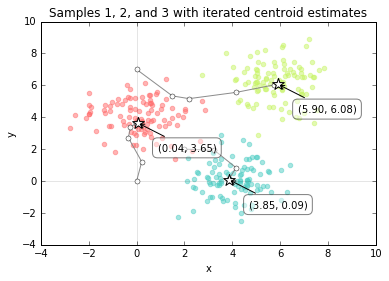

In [39]:
runWeightedKMeans(3, "/user/miki/week10/hw10_3/data.csv", 20)

Iteration   Centroid 1          Centroid 2          Centroid 3          
----------------------------------------------------------------------
0           ( 0.0000,  0.0000)  ( 2.0000,  2.0000)  ( 0.0000,  7.0000)  
1           ( 0.2148,  1.2093)  ( 3.2545,  1.9236)  ( 1.4917,  5.3409)  
2           (-0.3447,  2.7134)  ( 4.1510,  0.8470)  ( 2.1913,  5.1675)  
3           (-0.2584,  3.3841)  ( 3.8781,  0.1284)  ( 4.1677,  5.5618)  
4           (-0.0084,  3.6244)  ( 3.8462,  0.0908)  ( 5.7264,  6.0241)  
5           ( 0.0379,  3.6506)  ( 3.8462,  0.0908)  ( 5.8967,  6.0799)  

WSSSE = 381.417236


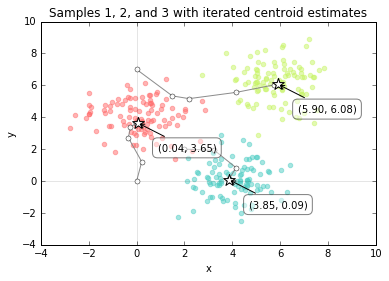

In [40]:
runWeightedKMeans(3, "/user/miki/week10/hw10_3/data.csv", 100)

## Comment on any differences between the results in HW10.3 and HW10.5. Explain.

The weighted points pull the centroids towards the x-axis, since the points with low x-values will have high weights. We can see this more readily in the clusters that are not centered on zero.

### Unweighted:
`Final Centroids: ( 0.0596,  3.8901)  ( 4.0867,  0.1017)  ( 5.9702,  6.1846)`

### Weighted:
`Final Centroids: ( 0.0379,  3.6506)  ( 3.8462,  0.0908)  ( 5.8967,  6.0799)`

# HW 10.6: Linear Regression (OPTIONAL)

## HW 10.6.1

Using the following linear regression notebook:

https://www.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb

Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

## Data Generation

In [41]:
import numpy as np
import csv

def data_generate(fileName, w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[0] + w[1] + noise)
    data = zip(y, x)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

## Data Visualization

In [42]:
import matplotlib.pyplot as plt

def dataPlot(file, w):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[0]),'o'+'r')
    plt.xlabel("x")
    plt.ylabel("y")
    x = [-4, 4]
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x,y, linewidth=2.0)
    plt.grid()
    plt.show()

## Create data sets and plot

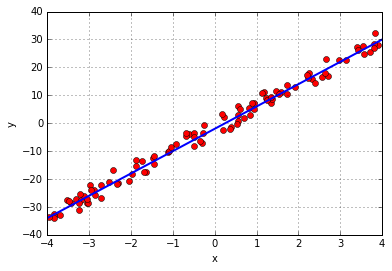

rm: `/user/miki/week10/hw10_6/train.csv': No such file or directory


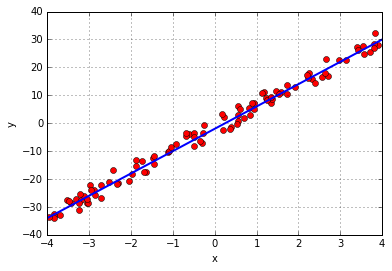

rm: `/user/miki/week10/hw10_6/test.csv': No such file or directory


In [43]:
w = [8,-2]

data_generate('train.csv', w, 100)
dataPlot('train.csv', w)

!hdfs dfs -rm -r /user/miki/week10/hw10_6/train.csv
!hdfs dfs -copyFromLocal train.csv /user/miki/week10/hw10_6/

data_generate('test.csv', w, 100)
dataPlot('test.csv', w)

!hdfs dfs -rm -r /user/miki/week10/hw10_6/test.csv
!hdfs dfs -copyFromLocal test.csv /user/miki/week10/hw10_6/

### Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots and words.

In [48]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

# Point parsing from http://spark.apache.org/docs/latest/mllib-linear-methods.html

def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return LabeledPoint(values[0], values[1:])

train_rdd = sc.textFile('/user/miki/week10/hw10_6/train.csv').map(parsePoint)
model = LinearRegressionWithSGD.train(train_rdd, iterations=1, intercept=True)